<a href="https://colab.research.google.com/github/chhsieh0225/Distributional-Robust-Kelly-Gambling/blob/master/Serially_correlated_Multi_asset_SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()
import datetime
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', size = 14)
import random
import cvxpy as cp
import matplotlib.colors as mcolors
from matplotlib import cm

# Functions

For only one asset:
- binomial_transform: 將return資料轉為 binomial values, {u,d} 以及 {0,1} 兩個 output
- Markov_coef: 估計 $\phi_i$
- probability: 估計 probability recursion model ups to stage k
- GL_price: 給定價格資料，計算 double linear policy 的 gain-loss；也可以給定return資料（設定 `ret = True`）；若設定`plot = True`，畫 V(k)-V(0) 的軌跡圖
- binomial_price: 長出 Monte Carlo 的價格資料，也可以output 出return(設定`ret = True`)

In [ ]:
# def u_d_movement(return_series):
#     'estimate the upward and downward factor'
#     u = np.exp(np.log(1+return_series[return_series>0]).mean())-1
#     d = np.exp(np.log(1+return_series[return_series<0]).mean())-1
#     return u, d

def binomial_transform(return_series, u, d):
    'transform the return data to binomial values {u, d}, and the response variable yk = {0, 1}'
    return_series = return_series.dropna()
    xk = (return_series > 0) * u + (return_series < 0) * d
    yk = (xk - d) / (u - d)
    return xk, yk


def Markov_coef(m, return_series, u, d, LS = False):
    'using cvxpy to solve the Markov coefficients for one asset'
    phi = cp.Variable(m+1)
    xk, yk = binomial_transform(return_series, u, d)

    X = xk
    Y = yk[m:]
    X_mat = np.vstack((np.ones(len(X)-m), [xk[i:-m+i] for i in range(m)])).T

    # use least-square to solve the optimal parameters for Markov coefficients
    if LS:
        beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(Y)
        return beta_hat

    # use cvxpy to find the estimated Markov coefficients
    else:
        constraint = [cp.abs(phi[0] - 0.5 + (u+d) * sum(phi[1:]) / 2) + (u-d) * sum(cp.abs(phi[1:]))/2 <= 1/2]
        cost = cp.sum_squares(X_mat @ phi - Y)
        prob = cp.Problem(cp.Minimize(cost), constraint)
        prob.solve()
        return phi.value


def probability(m, k, phi, u, d, return_series):
    'compute the probability recursion for one asset'
    yk = binomial_transform(return_series, u, d)[1]
    p = yk[-m:]
    phi_0 = phi[0]
    phi_i = phi[1:]
    for i in range(k):
        p = np.append(p, phi_0 + phi_i @ ((u-d) * p[-m:] + d))

    return p[m:]


def GL_price(alpha, weight, V0, price, ret = False, var = False, Rf = 0, plot = False, **kwargs):
    '''
    Input Variables:
    alpha: separate initial account value into long and short
    weight: time-varying admissible weight w(k), with length(w) = length(pre-period return), or constant is feasible
    V0: initial account value
    price: stock price with dimension ndays * simulationtimes
    ret: {'True': if input variable price data is of form pre-period return data, 'False': default, input price data is stock price}
    var: {'True': return expected gain-loss and corresponding variance, 'False': default, return expected gain-loss only}
    Rf: risk-free rate for long position, default = 0.00%
    plot: {'True': draw cumulative gain-loss figure, 'False': default}

    To compute cumulative gain-loss under given time-varying weight and stock price for one asset.
    '''

    X = price.fillna(0) if ret else price.pct_change(1).fillna(0)
    vl = V0 * alpha
    vs = V0 * (1-alpha)
    weight = np.array(weight)

#     VL = ((1 + weight * X.T).T.cumprod(axis = 0)) * vl
    VL = ((1 + weight * X.T + (1 - weight) * (Rf / 100) / 365).T.cumprod(axis = 0)) * vl
    VS = ((1 - weight * X.T).T.cumprod(axis = 0)) * vs
    V = VL + VS
    variance = (V.iloc[-1] - V0).var()  # variance of g(k)

    if plot:
        plt.plot(V-V0, **kwargs)

    if var:
        return V.iloc[-1].mean() - V0, variance
    else:
        return V.iloc[-1].mean() - V0


def GL_variance(alpha, weight, V0, price, ret = False):
    '''
    Compute cumulative gain-loss variance under given a price series or return series and weight function
    '''
    X = price.dropna() if ret else price.pct_change(1).dropna()  # price dimension with days * simulationtimes

    if (type(weight) == int) or (type(weight) == float):
        weight = [weight] * X.shape[0]
    weight = np.nan_to_num(weight)

    VL = ((1 + weight * X.T).T.cumprod(axis = 0)) * (V0 * alpha)
    VS = ((1 - weight * X.T).T.cumprod(axis = 0)) * (V0 * (1-alpha))
    V = VL+VS
    var_data = (V-V0).var() # trading cumulative gain-loss variance

    mu = X.mean()
    sig = X.std()
    var = alpha**2 *       ((weight * sig)**2 + (1 + weight * mu)**2).prod() + \
          (1 - alpha)**2 * ((weight * sig)**2 + (1 - weight * mu)**2).prod() + \
          2 * alpha * (1 - alpha) * ((1 - weight**2 * (sig**2 + mu**2)).prod()) - \
          alpha**2 *       ((1 + weight * mu)**2).prod() - \
          (1 - alpha)**2 * ((1 - weight * mu)**2).prod() - \
          2 * alpha * (1 - alpha) * ((1 - (weight * mu)**2).prod())
    var *= V0 **2

    return var_data
#     return var, var_data
#     return var, var_data, (V-V0)[-1]


def binomial_price(num_time, num_day, probability, S0, u, d):
    'Simulate the stock price with binomial lattice returns model for one asset'

    price_Corr = pd.DataFrame(columns = range(num_day+1), index = range(num_time))
    price_Corr[0] = S0

    ret_simulation = pd.DataFrame([np.random.binomial(1, probability) for i in range(num_time)]) * (u - d) + d
    price_Corr[price_Corr.columns[1:]] = (1 + ret_simulation).values
    price_Corr = price_Corr.cumprod(axis = 1)

    return price_Corr.T


Functions for multi-assets:
- u_d_movement: 給定 return 資料，估計 movement factors
- Markov_coef_portfolio: 同時估計多個資產的 $\Phi_{i,j}$，須先給定 correaltion matrix
- probability_portfolio: 同時估計多個資產的 probability recursion model，output 是矩陣的樣子
- binomial_price_portfolio: 同時生成多個資產的 Monte Carlo stock price，同樣可output return 資料（設定`ret = True`）
- GL_price_portfolio: 計算多資產的 multi-double linear policy 的 gain-loss。關於 Input variables:
    - `alpha`: 為一constant
    - `weight_list`: 以pd.Series 型式存在，要讀取得到 `weight_list['AAPL']` 為 constant weight for AAPL
    - `vi`: initial allocation, 以 pd.Series 形式存在，也就是要讀得到 `vi['AAPL']` 資料
    - `plot = True`: 畫 V(k) - V(0) 的走勢圖
    - `plotV = True`: 畫 VL(k) 跟 VS(k) 的走勢圖
    - `ret = True`: 代表 input 的 price 是 return 資料，而不是股價資料
    - `Rf, cost`: default 為0
    

In [ ]:
def u_d_movement(return_series):
    'estimate the upward and downward factor'
    U = np.exp(np.log(1+return_series[return_series>0]).mean())-1
    D = np.exp(np.log(1+return_series[return_series<0]).mean())-1
    return U, D


def Markov_coef_portfolio(m, return_series, U, D, Gamma):
    'using cvxpy to solve the Markov coefficients'
    Phi = pd.DataFrame(index = U.index, columns = range(m+1))
    xk, yk = binomial_transform(return_series, U, D)
    comp_list = U.index

    for comp in comp_list:
        phi = cp.Variable(m+1)

        X = xk[comp]
        Y = yk[comp][m:]
        X_mat = np.vstack((np.ones(len(X)-m), [xk[comp][m-(i+1):-(i+1)] for i in range(m)])).T

        constraint = [cp.abs(phi[0] - 0.5 + (U[comp]+D[comp]) * sum(phi[1:])/2 + (U+D)/2 @ Gamma[comp]) +
                      (U[comp]-D[comp]) * sum(cp.abs(phi[1:]))/2 + sum((U-D)/2 * abs(Gamma[comp])) <= 1/2]
        corr_term =  (xk[m-1:-1] @ Gamma[comp]).values
        cost = cp.sum_squares(X_mat @ phi + corr_term - Y)
        prob = cp.Problem(cp.Minimize(cost), constraint)
        prob.solve()
        Phi.loc[comp] = phi.value
    return Phi

def probability_portfolio(m, k, Phi, U, D, return_matrix, Gamma):
    'compute the probability recursion'
    yk = binomial_transform(return_matrix, U, D)[1]
    prob_matrix = pd.DataFrame(yk.iloc[-m:].T.values, index = U.index, columns = range(m))

    for i in range(k):
        new_prob = Phi.iloc[:,0] + (U-D) * (Phi.iloc[:,1:].values *  prob_matrix.iloc[:,-1:-m-1:-1].values).sum(axis = 1) + (Phi.iloc[:,1:].values).sum(axis = 1) * D + (Gamma @ ((U-D) * prob_matrix.iloc[:,-1] + D))
        prob_matrix = pd.concat([prob_matrix, new_prob], axis = 1, ignore_index = True)

    return prob_matrix.iloc[:,m:].copy().set_axis(range(len(prob_matrix.columns)-m), axis = 1)

def binomial_price_portfolio(num_time, num_day, Probability_matrix, S0, U, D, ret = False):
    'Simulate the stock price with binomial lattice returns model'
    comp_list = U.index
    simulation_price = {}

    for comp in comp_list:

        s0 = S0[comp]
        probability = Probability_matrix.loc[comp]
        u = U[comp]
        d = D[comp]

        price_Corr = pd.DataFrame(columns = range(num_day+1), index = range(num_time))


        ret_simulation = pd.DataFrame([np.random.binomial(1, probability) for i in range(num_time)]) * (u - d) + d

        if ret:
            price_Corr[0] = 0
            price_Corr[price_Corr.columns[1:]] = ret_simulation.values
            simulation_price[comp] = price_Corr.T

        else:
            price_Corr[0] = s0
            price_Corr[price_Corr.columns[1:]] = (1 + ret_simulation).values
            price_Corr = price_Corr.cumprod(axis = 1)
            simulation_price[comp] = price_Corr.T

    return simulation_price

def GL_price_portfolio(alpha, weight_list, V0, vi, Price, ret = False, var = False, Rf = 0, cost = 0, gain = False, plot = False, plotV = False, **kwargs):
    'compute the gain-loss for multi-double linear policy'

    comp_list = Price.keys()
    VL_all = 0
    VS_all = 0
    for i, comp in enumerate(comp_list):

        price = Price[comp]
        X = price.fillna(0) if ret else price.pct_change(1).fillna(0)
        vl = V0 * vi[comp] * alpha * 100
        vs = V0 * vi[comp] * (1-alpha) * 100
        weight = np.array(weight_list[comp])

        # for zero risk-free rate
        # VL = ((1 + weight * X.T).T.cumprod(axis = 0)) * vl

        # for non-zero risk-free rate
        # VL = ((1 + weight * X.T + (1 - weight) * (Rf / 100) / 365).T.cumprod(axis = 0)) * vl
        # VS = ((1 - weight * X.T).T.cumprod(axis = 0)) * vs

        # for non-zero transaction cost
        VL = ((1 + weight * (X - (cost/100)).T + (1 - weight) * (Rf / 100) / 365).T.cumprod(axis = 0)) * vl
        VS = ((1 - weight * (X + (cost/100)).T).T.cumprod(axis = 0)) * vs

        VL_all += VL/100
        VS_all += VS/100

    account = VL_all + VS_all

    variance = (account.iloc[-1] - V0).var()  # variance of g(k)

    if plot:
        print(account.iloc[-1].mean() - V0)
        return plt.plot(account-V0, **kwargs)

    if plotV:
        plt.plot(VL_all, **kwargs)
        plt.plot(VS_all, **kwargs)

    if gain:
        return account - V0  # return the gain-loss matrix

    if var:
        return (account.iloc[-1].mean() - V0), variance
    else:
        return (account.iloc[-1].mean() - V0)

## Set gradient color

In [ ]:
# set colors
cm = plt.get_cmap('tab20c')
orange = [plt.cm.Oranges(i) for i in np.linspace(1, 0, 6)]
green = [plt.cm.Greens(i) for i in np.linspace(1, 0, 6)]
blue  = [plt.cm.Blues(i) for i in np.linspace(1, 0, 6)]
purple = [plt.cm.Purples(i) for i in np.linspace(1, 0, 8)]
grey = [plt.cm.Greys(i) for i in np.linspace(1, 0, 6)]
color_list = { 'blue': blue,'orange': orange, 'green': green, 'purple': purple, 'grey':grey}

dashdotdotted = (0,(3,5,1,5,1,5))
ls_list = ['-', '--', '-.', ':', dashdotdotted]

# S&P 500 top 30

## Stock Price data

讀 2022 跟 2023 年的 DJIA components 價格資料

In [ ]:
SPY_comp = {'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'GOOG', 'BRK-B', 'TSLA', 'UNH',
            'JNJ', 'JPM', 'XOM', 'LLY', 'V', 'PG', 'AVGO', 'HD', 'MA', 'CVX',
            'MRK', 'ABBV', 'PEP', 'COST', 'ADBE', 'KO', 'WMT', 'CSCO', 'MCD', 'BAC'}
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2023, 12, 31)
SPY_Price = pd.DataFrame(pdr.get_data_yahoo(SPY_comp, start, end)['Adj Close'])
SPY_Return = SPY_Price.pct_change(1)

comp_list = SPY_Price.columns
comp_list1 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'GOOG', 'BRK-B', 'TSLA', 'UNH']
comp_list2 = ['JNJ', 'JPM', 'XOM', 'LLY', 'V', 'PG', 'AVGO', 'HD', 'MA', 'CVX']
comp_list3 = ['MRK', 'ABBV', 'PEP', 'COST', 'ADBE', 'KO', 'WMT', 'CSCO', 'MCD', 'BAC']

[*********************100%%**********************]  30 of 30 completed


In [ ]:
# SPY_Price.to_csv('SPY30_price.csv')

In [ ]:
SPY_Price = pd.read_csv('SPY30_price.csv', index_col = 0)
SPY_Price.index = pd.to_datetime(SPY_Price.index)
comp_list = SPY_Price.columns
SPY_Return = SPY_Price.pct_change(1)

comp_list1 = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'GOOG', 'BRK-B', 'TSLA', 'UNH']
comp_list2 = ['JNJ', 'JPM', 'XOM', 'LLY', 'V', 'PG', 'AVGO', 'HD', 'MA', 'CVX']
comp_list3 = ['MRK', 'ABBV', 'PEP', 'COST', 'ADBE', 'KO', 'WMT', 'CSCO', 'MCD', 'BAC']

In [ ]:
SPY_Price2022 = SPY_Price['2022-01-01':'2022-12-31']
SPY_Return2022 = SPY_Return['2022-01-01':'2022-12-31']

SPY_Price2023 = SPY_Price['2023-01-01':'2023-7-31']
SPY_Return2023 = SPY_Return['2023-01-01':'2023-7-31']

## Simulate with different weight

In [ ]:
day = 252
m = 10  # tune here to adjust the Markov memory length m
Data = SPY_Price2022
Return = SPY_Return2022

n = len(Data.columns)
V0 = 1
alpha = 0.5

S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)  # correlation matrix, Gamma
U, D = u_d_movement(Return)  # estimate upward and downward movement factor, u, d
Phi = Markov_coef_portfolio(m, Return, U, D, correlation)  # estimate Phi_ij
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)  # estimate probability recursion model, p_i(j)

C:\Users\acer\anaconda3\Lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# Phi.to_csv('Phi_ij_m10.csv')

In [ ]:
# correlation.to_csv('Gamma.csv')

In [ ]:
# (pd.DataFrame([U, D], columns = comp_list).T).to_csv('ud_factor.csv')

In [ ]:
# Phi.to_csv('Phi_ij_m1.csv')

In [ ]:
# generate the workday date to plot the figure
import matplotlib.dates as mdates
from pandas.tseries.holiday import USFederalHolidayCalendar

holidays = USFederalHolidayCalendar().holidays(start='2023-01-01', end='2023-12-31').to_pydatetime()

workday_2023 = pd.date_range('2022-12-30', '2023-12-31', freq = 'B')
test_date = workday_2023.drop(date for date in holidays[:-3])  # len = 252, list of the workday for 2023

In [ ]:
repeat = 500  # tune here for simulation times
day = 252
m = 5  # tune here for the Markov memory length, m
Data = SPY_Price2022
Return = SPY_Return2022
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)
U, D = u_d_movement(Return)
Phi = Markov_coef_portfolio(m, Return, U, D, correlation)

probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)
np.random.seed(65)  # tune here for random seed
simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


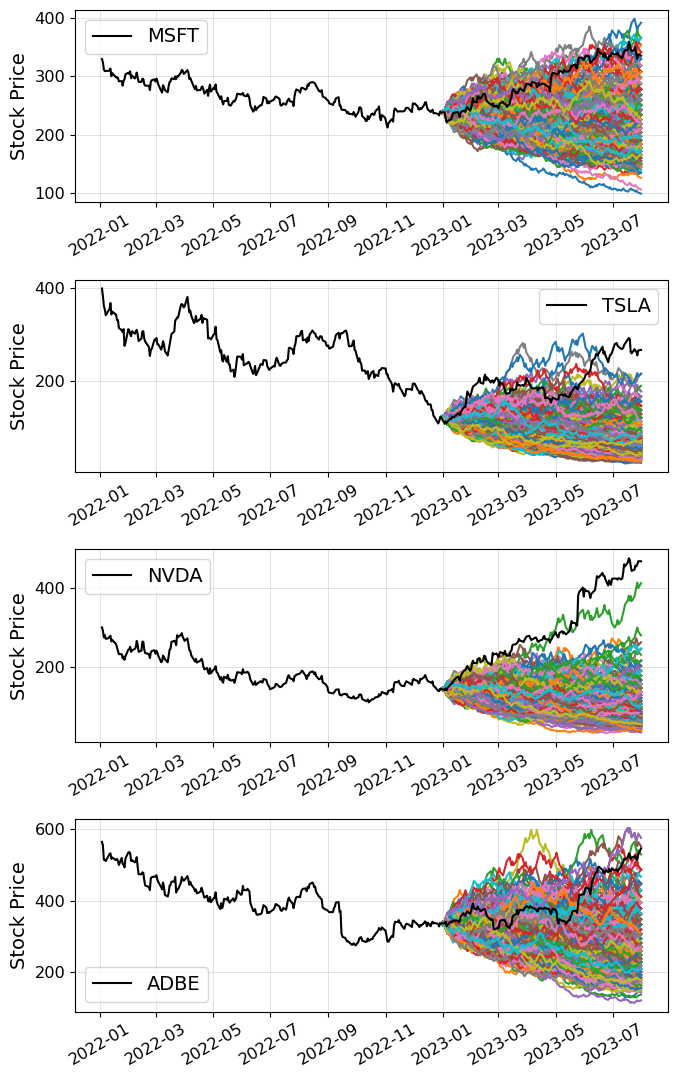

In [ ]:
plt.figure(figsize = (7, 11))
for i, c in enumerate(['MSFT', 'TSLA', 'NVDA', 'ADBE']):  # adjust the different assets
    plt.subplot(4,1,i+1)  # also adjust here if plot more than 4 assets
    d = len(SPY_Price2023)+2
    plt.plot(pd.DataFrame(simu_price[c].iloc[:d,].values,index = test_date[:d]))  # simulation stock price
    plt.plot(pd.concat([SPY_Price2022[c],SPY_Price2023[c]]), color = 'k', label = c)  # the real stock price
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
    plt.xticks(fontsize = 'small')
    plt.yticks(fontsize = 'small')
    plt.ylabel('Stock Price')
    plt.tick_params(axis='x', labelrotation=30)
    plt.legend()
plt.tight_layout()
# plt.savefig('portfolio_Monte_Carlo.eps', format = 'eps', bbox_inches='tight', dpi =600)

### An example of simulate multi-double linear policy for m=1

In [ ]:
repeat = 1000
day = 252
m = 1
Data = SPY_Price2022
Return = SPY_Return2022

n = len(Data.columns)
V0 = 1
alpha = 0.5
vi = pd.Series([1/n] * n, index = comp_list)

GL_diff_w_m1 = []
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)
U, D = u_d_movement(Return)
Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)

for w in np.linspace(0, 1, 101):
    weight = pd.Series([w] * n, index = comp_list)
    simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
    GL_diff_w_m1.append(GL_price_portfolio(alpha, weight, V0, vi, simu_price, ret = True))

## Simulate for vi = vEW
模擬在 vi = vEW 時，不同 m 和不同 weight 的結果

***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面兩個 cell 直接讀取 csv 檔**

In [ ]:
repeat = 10000  # tune here to adjust the simulation times
day = 252
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)  # estimate upward and downward movement factor

n = len(Data.columns)
V0 = 1
alpha = 0.5
vEW = pd.Series([1/n] * n, index = comp_list)  # equal weight allocation, vEW
weight_list = np.linspace(0, 1, 101)  # varying weight from 0 to 1
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)  # correlation matrix, Gamma

m_list = [1,2,5,10]
GL_weight_vEW = pd.DataFrame(index = weight_list, columns = m_list)
std_weight_vEW = pd.DataFrame(index = weight_list, columns = m_list)

for m in m_list:
    Phi = Markov_coef_portfolio(m, Return, U, D, correlation)  # estimate the phi_i parameters
    probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)  # estimate the probability recursion model
    GL_diff_w = []
    std_diff_w = []
    for w in weight_list:
        weight = pd.Series([w] * n, index = comp_list)
        simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)  # Monte Carlo simulation
        result = GL_price_portfolio(alpha, weight, V0, vEW, simu_price, ret = True, var = True)  # compute the gain-loss and std of the simulation results
        GL_diff_w.append(result[0])
        std_diff_w.append(np.sqrt(result[1]))
    GL_weight_vEW[m] = GL_diff_w
    std_weight_vEW[m] = std_diff_w

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# GL_weight_vEW.to_csv('GL_weight_vEW.csv')
# std_weight_vEW.to_csv('std_weight_vEW.csv')

In [ ]:
# read the csv file for the simulation results for equal weight, vEW
GL_weight_vEW = pd.read_csv('GL_weight_vEW.csv', index_col = 0)
GL_weight_vEW.columns = GL_weight_vEW.columns.astype(int)
std_weight_vEW = pd.read_csv('std_weight_vEW.csv', index_col = 0)
std_weight_vEW.columns = std_weight_vEW.columns.astype(int)
m_list = [1,2,5,10]

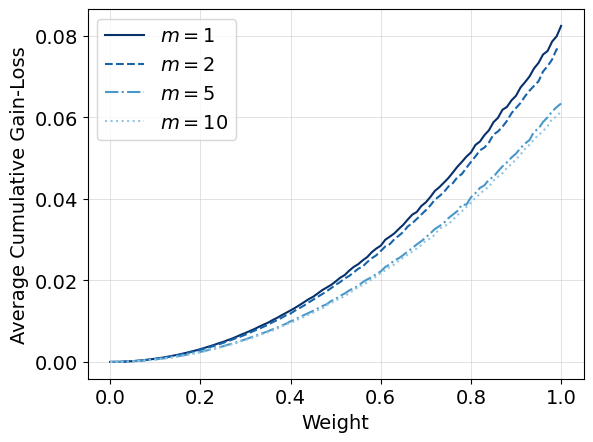

In [ ]:
# plot the average cumulative gain-loss against weights with varying m for vEW
for i,m in enumerate(m_list):
    plt.plot(GL_weight_vEW[m], color = blue[i], ls = ls_list[i])
plt.xlabel('Weight')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend(['$m=1$', '$m=2$', '$m=5$', '$m=10$'])
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

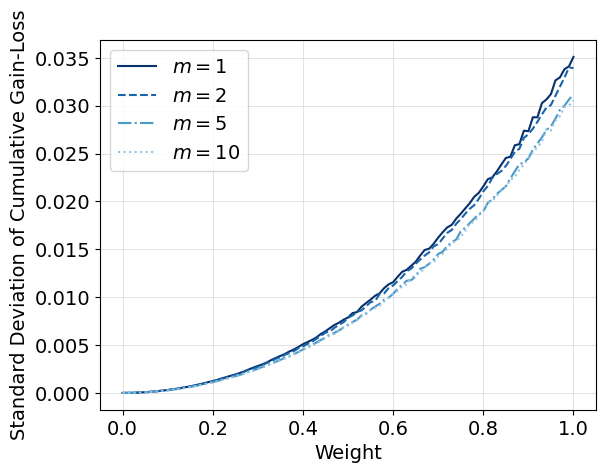

In [ ]:
# plot the standard deviation cumulative gain-loss against weights with varying m for vEW
for i,m in enumerate(m_list):
    plt.plot(std_weight_vEW[m], color = blue[i], ls = ls_list[i])
plt.xlabel('Weight')
plt.ylabel('Standard Deviation of Cumulative Gain-Loss')
plt.legend(['$m=1$', '$m=2$', '$m=5$', '$m=10$'])
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

## Use `capital-weighted` as initial allocation variable, vi = vCW

Capital-weight index

模擬在 vi = vCW 時，不同 m 和不同 weight 的結果

***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面兩個 cell 直接讀取 csv 檔**

In [ ]:
# the S&P500 index weight
vCW = pd.Series([7.082221, 6.462999, 3.270944, 2.917615, 2.075205, 1.790753, 1.766906, 1.713921, 1.649578, 1.272445,
                 1.215898, 1.191206, 1.167809, 1.166878, 1.050958, 0.979805, 0.942146, 0.915318, 0.895624, 0.758653,
                 0.748802, 0.726528, 0.676535, 0.672491, 0.640516, 0.638105, 0.605428, 0.588463, 0.56529, 0.551154],
                index = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'TSLA', 'UNH',
                         'JNJ', 'JPM', 'LLY', 'XOM', 'V', 'PG', 'AVGO', 'HD', 'MA', 'CVX',
                         'MRK', 'ABBV', 'PEP', 'COST', 'ADBE', 'KO', 'WMT', 'CSCO', 'MCD', 'BAC'])
vCW = vCW/vCW.sum()  # adjust to total sum of 1

In [ ]:
repeat = 10000  # tune here to adjust the simulation times
day = 252
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)

n = len(Data.columns)
V0 = 1
alpha = 0.5
# vPW = (Data.iloc[-1] / sum(Data.iloc[-1])) # price-weighted allocation, as the index weight

S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)
weight_list = np.linspace(0, 1, 101)

m_list = [1,2,5,10]
GL_weight_vCW = pd.DataFrame(index = weight_list, columns = m_list)
std_weight_vCW = pd.DataFrame(index = weight_list, columns = m_list)

for m in m_list:
    Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
    probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)
    GL_vCW_m = []
    std_vCW_m = []
    for w in weight_list:
        weight = pd.Series([w] * n, index = U.index)
        simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
        result = GL_price_portfolio(alpha, weight, V0, vCW, simu_price, ret = True, var = True)
        GL_vCW_m.append(result[0])
        std_vCW_m.append(np.sqrt(result[1]))
    GL_weight_vCW[m] = GL_vCW_m
    std_weight_vCW[m] = std_vCW_m


C:\Users\acer\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# GL_weight_vCW.to_csv('GL_weight_vCW.csv')
# std_weight_vCW.to_csv('std_weight_vCW.csv')

In [ ]:
# read the csv file for the simulation results for capital weight, vCW
m_list = [1,2,5,10]
GL_weight_vCW = pd.read_csv('GL_weight_vCW.csv', index_col = 0)
GL_weight_vCW.columns = GL_weight_vCW.columns.astype(int)
std_weight_vCW = pd.read_csv('std_weight_vCW.csv', index_col = 0)
std_weight_vCW.columns = std_weight_vCW.columns.astype(int)
vCW = pd.Series([7.082221, 6.462999, 3.270944, 2.917615, 2.075205, 1.790753, 1.766906, 1.713921, 1.649578, 1.272445,
                 1.215898, 1.191206, 1.167809, 1.166878, 1.050958, 0.979805, 0.942146, 0.915318, 0.895624, 0.758653,
                 0.748802, 0.726528, 0.676535, 0.672491, 0.640516, 0.638105, 0.605428, 0.588463, 0.56529, 0.551154],
                index = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'TSLA', 'UNH',
                         'JNJ', 'JPM', 'LLY', 'XOM', 'V', 'PG', 'AVGO', 'HD', 'MA', 'CVX',
                         'MRK', 'ABBV', 'PEP', 'COST', 'ADBE', 'KO', 'WMT', 'CSCO', 'MCD', 'BAC'])
vCW = vCW/vCW.sum()

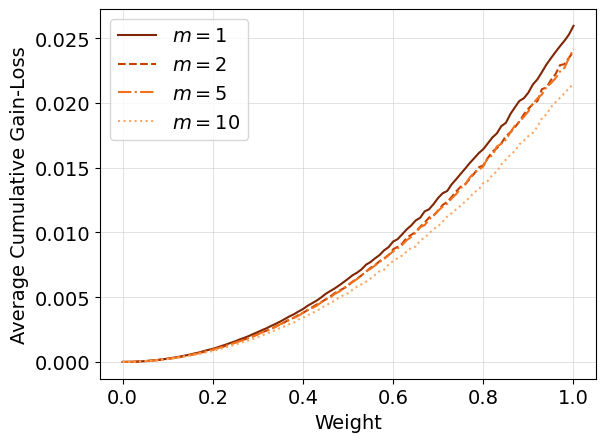

In [ ]:
# plot the average cumulative gain-loss against weights with varying m for vCW
for i, m in enumerate(m_list):
    plt.plot(GL_weight_vCW[m], color = orange[i], ls = ls_list[i])
plt.xlabel('Weight')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend(['$m=1$', '$m=2$', '$m=5$', '$m=10$'])
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

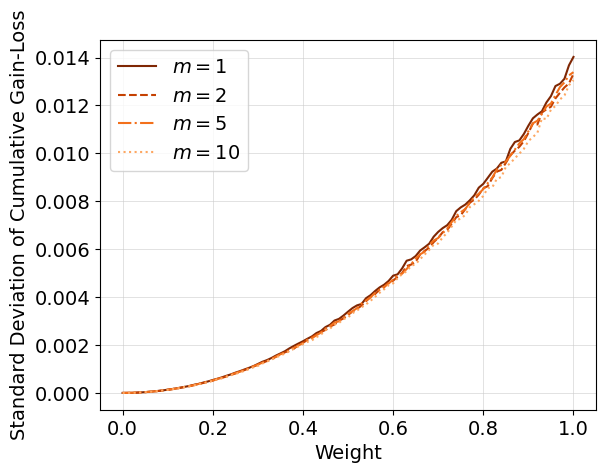

In [ ]:
# plot the average cumulative gain-loss against weights with varying m for vCW
for i, m in enumerate(m_list):
    plt.plot(std_weight_vCW[m], color = orange[i], ls = ls_list[i])
plt.xlabel('Weight')
plt.ylabel('Standard Deviation of Cumulative Gain-Loss')
plt.legend(['$m=1$', '$m=2$', '$m=5$', '$m=10$'])
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

## Use traingind data `gain-loss-weighted` as criterion for initial allocation parameters

用 training data 的 gain-loss 當作 vi 的判斷標準
$$v_{GL} = \frac{|\overline{\mathcal{G}}_i(k)|}{\sum_{i=1}^{n}|\overline{\mathcal{G}}_i(k)|}$$
where $\overline{\mathcal{G}}_i(k)$ computed by $\overline{\mathcal{G}}_i(k) = \frac{S_i(k)-S_i(0)}{S_i(0)}$

***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面兩個 cell 直接讀取 csv 檔**

In [ ]:
repeat = 10000  # tune here to adjust the simulation times
day = 252
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)

n = len(Data.columns)
V0 = 1
alpha = 0.5
vGL = abs(Data.pct_change(n-1).iloc[-1]) / abs(Data.pct_change(n-1).iloc[-1]).sum()  # compute the vGL of the training data
weight_list = np.linspace(0, 1, 101)
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)

m_list = [1,2,5,10]
GL_weight_vGL = pd.DataFrame(index = weight_list, columns = m_list)
std_weight_vGL = pd.DataFrame(index = weight_list, columns = m_list)

for m in m_list:
    Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
    probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)
    GL_diff_w = []
    std_diff_w = []
    for w in weight_list:
        weight = pd.Series([w] * n, index = U.index)
        simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
        result = GL_price_portfolio(alpha, weight, V0, vGL, simu_price, ret = True, var = True)
        GL_diff_w.append(result[0])
        std_diff_w.append(np.sqrt(result[1]))
    GL_weight_vGL[m] = GL_diff_w
    std_weight_vGL[m] = std_diff_w


In [ ]:
# GL_weight_vGL.to_csv('GL_weight_vGL.csv')
# std_weight_vGL.to_csv('std_weight_vGL.csv')

In [ ]:
# read the csv file for the simulation results for gain-loss weight, vGL
GL_weight_vGL = pd.read_csv('GL_weight_vGL.csv', index_col = 0)
GL_weight_vGL.columns = GL_weight_vGL.columns.astype(int)
std_weight_vGL = pd.read_csv('std_weight_vGL.csv', index_col = 0)
std_weight_vGL.columns = std_weight_vGL.columns.astype(int)
m_list = [1,2,5,10]

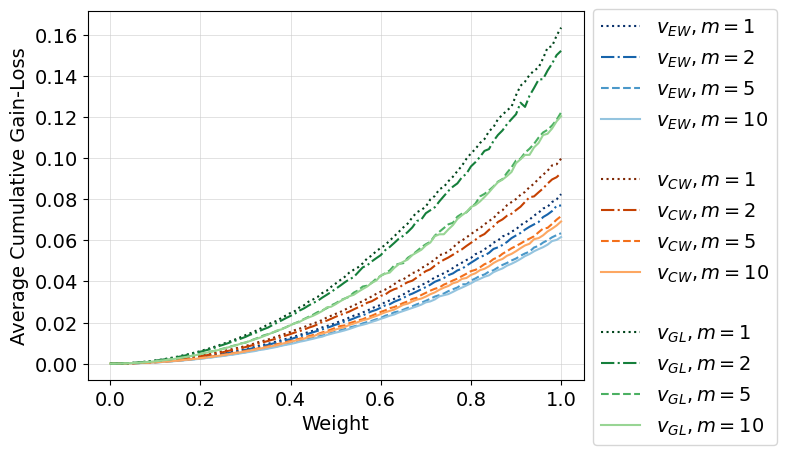

In [ ]:
# plot the figure of average cumulative gain-loss against weight with various allocation vi: vEW, vCW, vGL
for i,m in enumerate(m_list):  # for vEW
    plt.plot(GL_weight_vEW[m], color = blue[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vCW
    plt.plot(GL_weight_vCW[m], color = orange[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vGL
    plt.plot(GL_weight_vGL[m], color = green[i], ls = ls_list[3-i])
plt.xlabel('Weight')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend(['$v_{EW}, m=1$', '$v_{EW},m=2$', '$v_{EW},m=5$', '$v_{EW},m=10$', '',
            '$v_{CW},m=1$', '$v_{CW},m=2$', '$v_{CW},m=5$', '$v_{CW},m=10$', '',
            '$v_{GL},m=1$', '$v_{GL},m=2$', '$v_{GL},m=5$', '$v_{GL},m=10$'], bbox_to_anchor=(1.0, 1.03))
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_gain_vEW_vCW_vGL.eps', format = 'eps', bbox_inches='tight', dpi =600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


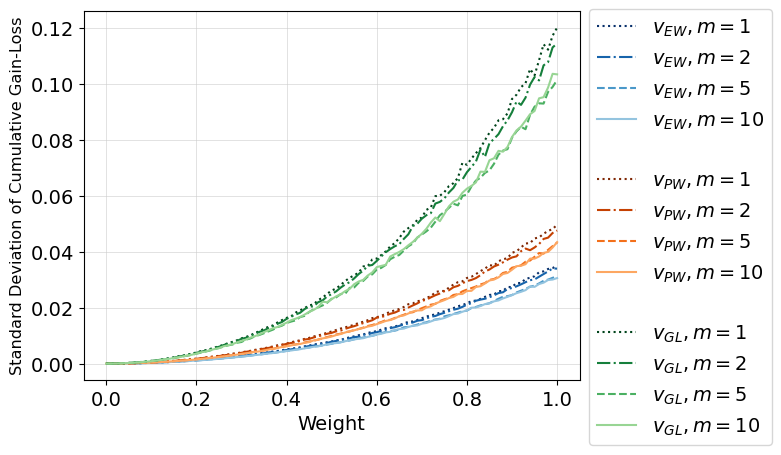

In [ ]:
# plot the figure of standard deviation of cumulative gain-loss against weight with various allocation vi: vEW, vCW, vGL
for i,m in enumerate(m_list):  # for vEW
    plt.plot(std_weight_vEW[m], color = blue[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vCW
    plt.plot(std_weight_vCW[m], color = orange[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vGL
    plt.plot(std_weight_vGL[m], color = green[i], ls = ls_list[3-i])
plt.xlabel('Weight')
plt.ylabel('Standard Deviation of Cumulative Gain-Loss', fontsize = 'small')
plt.legend(['$v_{EW}, m=1$', '$v_{EW},m=2$', '$v_{EW},m=5$', '$v_{EW},m=10$', '',
            '$v_{PW},m=1$', '$v_{PW},m=2$', '$v_{PW},m=5$', '$v_{PW},m=10$', '',
            '$v_{GL},m=1$', '$v_{GL},m=2$', '$v_{GL},m=5$', '$v_{GL},m=10$'], bbox_to_anchor=(1.0, 1.03))

plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_std_vEW_vCW_vGL.eps', format = 'eps', bbox_inches='tight', dpi =600)

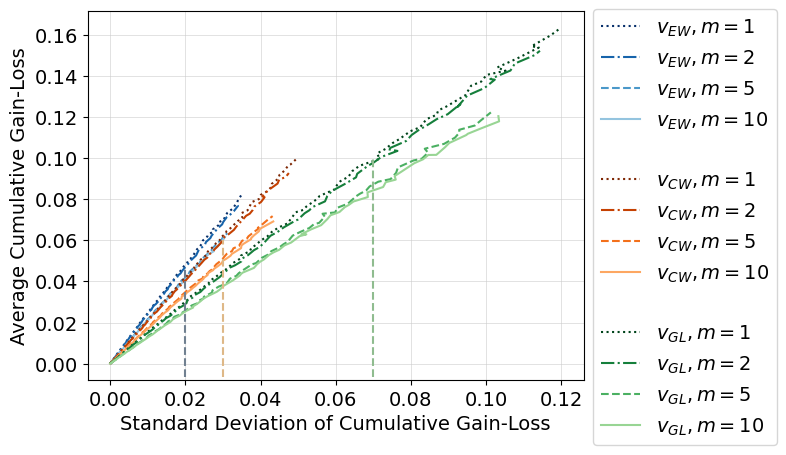

In [ ]:
# plot the figure of average cumulative gain-loss against standard deviation with various allocation vi: vEW, vCW, vGL
for i,m in enumerate(m_list):  # for vEW
    plt.plot(std_weight_vEW[m], GL_weight_vEW[m], color = blue[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vCW
    plt.plot(std_weight_vCW[m], GL_weight_vCW[m],  color = orange[i], ls = ls_list[3-i])
plt.plot([], ls = '')
for i,m in enumerate(m_list):  # for vGL
    plt.plot(std_weight_vGL[m], GL_weight_vGL[m], color = green[i], ls = ls_list[3-i])

plt.axvline(x=0.02, ymin=0.01, ymax=0.3, ls = '--', color = 'slategrey')
plt.axvline(x=0.03, ymin=0.01, ymax=0.38, ls = '--', color = 'burlywood')
plt.axvline(x=0.07, ymin=0.01, ymax=0.6, ls = '--', color = 'darkseagreen')


plt.xlabel('Standard Deviation of Cumulative Gain-Loss')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend(['$v_{EW}, m=1$', '$v_{EW},m=2$', '$v_{EW},m=5$', '$v_{EW},m=10$', '',
            '$v_{CW},m=1$', '$v_{CW},m=2$', '$v_{CW},m=5$', '$v_{CW},m=10$', '',
            '$v_{GL},m=1$', '$v_{GL},m=2$', '$v_{GL},m=5$', '$v_{GL},m=10$'], bbox_to_anchor=(1.0, 1.03))

plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_std_GL_vEW_vCW_vGL.eps', format = 'eps', bbox_inches='tight', dpi =600)

## Simulate with different `risk-free rate`

***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面兩個 cell 直接讀取 csv 檔**

In [ ]:
repeat = 10000  # tune here for simulation times
day = 252
m = 1
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)

n = len(Data.columns)
V0 = 1
alpha = 0.5
rf_list = [0.92, 1.51, 3.88]  # tune here to adjust the risk-free rate
vEW = pd.Series([1/n] * n, index = comp_list)  # adjust here to change to different allocation, vi
weight_list = np.linspace(0, 1, 101)

GL_diff_w_rf_m1 = []
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)

Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)
GL_diff_rf = pd.DataFrame(index = weight_list, columns = rf_list)

for rf in rf_list:
    GL_diff_w_rf_m1 = []
    for w in weight_list:
        weight = pd.Series([w] * n, index = comp_list)
        simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
        GL_diff_w_rf_m1.append(GL_price_portfolio(alpha, weight, V0, vEW, simu_price, ret = True, Rf = rf))
    GL_diff_rf[rf] = GL_diff_w_rf_m1

In [ ]:
# GL_diff_rf.to_csv('GL_diff_rf.csv')

In [ ]:
# read the csv file of the simulation results for different risk-free rate
GL_diff_rf = pd.read_csv('GL_diff_rf.csv', index_col = 0)
GL_diff_rf.columns = GL_diff_rf.columns.astype(float)
m_list = [1,2,5,10]
rf_list = [0.92, 1.51, 3.88]

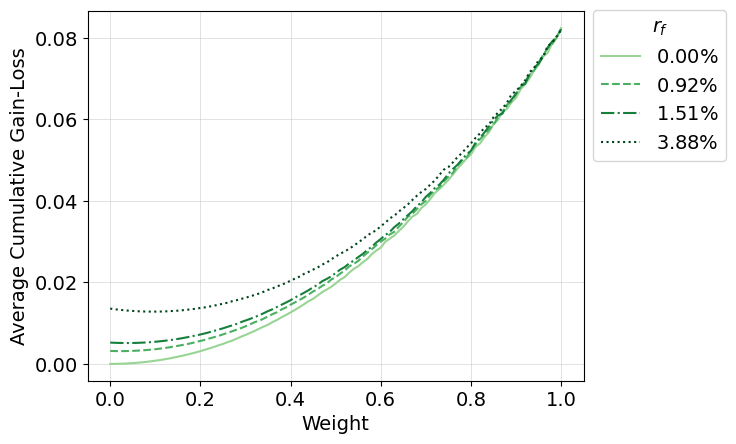

In [ ]:
# plot the figure of average cumulative gain-loss against weight with various risk-free rate rf: 0.92, 1.51, 3.88%
plt.plot(GL_weight_vEW[1], color = green[3])
for i, rf in enumerate(rf_list):
    plt.plot(GL_diff_rf[rf], color = green[2-i], ls = ls_list[i+1])

plt.xlabel('Weight')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend(['$0.00\%$', '$0.92\%$', '$1.51\%$', '$3.88\%$'],title = '$r_f$', bbox_to_anchor=(1.0, 1.03))
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_GL_Rf.eps', format = 'eps', bbox_inches='tight', dpi =600)

## Simulate with different alpha
***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面兩個 cell 直接讀取 csv 檔**

In [ ]:
repeat = 10000  # tune here for simulation times
day = 252
m = 1  # tune here for memory length, m
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)

n = len(Data.columns)
V0 = 1
vEW = pd.Series([1/30] * 30, index = comp_list)  # adjust here for different allocation vi
weight_list = np.linspace(0, 1, 101)
alpha_list = [0.1,0.3,0.5,0.7,0.9]

S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)

Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)
GL_weight_alpha = pd.DataFrame(index = weight_list, columns = alpha_list)

for alpha in alpha_list:
    GL_diff_w = []
    for w in weight_list:
        weight = pd.Series([w] * n, index = comp_list)
        simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
        GL_diff_w.append(GL_price_portfolio(alpha, weight, V0, vEW, simu_price, ret = True))
    GL_weight_alpha[alpha] = GL_diff_w

In [ ]:
# GL_weight_alpha.to_csv('GL_weight_alpha.csv')

In [ ]:
# read csv file of the simulation results for various alpha
alpha_list = [0.1,0.3,0.5,0.7,0.9]
GL_weight_alpha = pd.read_csv('GL_weight_alpha.csv', index_col = 0)
GL_weight_alpha.columns = GL_weight_alpha.columns.astype(float)

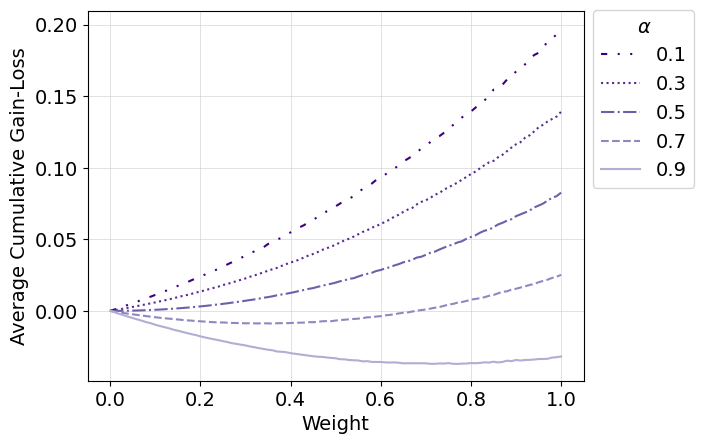

In [ ]:
# plot the figure of average cumulative gain-loss against weight with various alpha: {0.1, 0.3, 0.5, 0.7, 0.9}
for i, alpha in enumerate(alpha_list):
    plt.plot(GL_weight_alpha[alpha], color = purple[i], ls = ls_list[4-i])
plt.xlabel('Weight')
plt.ylabel('Average Cumulative Gain-Loss')
plt.legend([0.1,0.3,0.5,0.7,0.9], title = '$\\alpha$', bbox_to_anchor=(1.0, 1.03))
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_gain_differ_alpha.eps', format = 'eps', bbox_inches='tight', dpi =600)

## Find Optimal Weight

In [ ]:
# for vEW, the equal weight allocation for m=1
m = 1  # tune here to get the different memory length optimal weight for vEW
std_diff_w_m1 = std_weight_vEW[m]
GL_diff_w_m1 = GL_weight_vEW[m]

wEW = (std_diff_w_m1[std_diff_w_m1<0.02]).index[-1]  # tune the threshold for the target standard deviation
print('std: ', std_diff_w_m1[wEW])
print('Gain-Loss: ', GL_diff_w_m1[wEW])
print('weight EW: ', wEW)

std:  0.0198200486887103
Gain-Loss:  0.0479204482500521
weight EW:  0.77


In [ ]:
# for vCW, the price-weighted index allocation for m=1
m = 1  # tune here to get the different memory length optimal weight for vCW
std_diff_w_m1 = std_weight_vCW[m]
GL_diff_w_m1 = GL_weight_vCW[m]

wCW = (std_diff_w_m1[std_diff_w_m1<0.03]).index[-1]  # tune the threshold for the target standard deviation
print('std: ', std_diff_w_m1[wCW])
print('Gain-Loss: ', GL_diff_w_m1[wCW])
print('weight PW: ', wCW)

std:  0.0293914087273576
Gain-Loss:  0.0614041008400114
weight PW:  0.79


In [ ]:
# for vGL, the gain-loss index allocation for m=1
m = 1  # tune here to get the different memory length optimal weight for vGL
std_diff_w_m1 = std_weight_vGL[m]
GL_diff_w_m1 = GL_weight_vGL[m]

wGL = (std_diff_w_m1[std_diff_w_m1<0.07]).index[-1]  # tune the threshold for the target standard deviation
print('std: ', std_diff_w_m1[wGL])
print('Gain-Loss: ', GL_diff_w_m1[wGL])
print('weight : ', wGL)

std:  0.0663235321063665
Gain-Loss:  0.0962510385395396
weight :  0.78


## Find optimal weight separately, $v_{\rm vary}$
***注意:若設定 repeat = 10000 會跑很久！！***
**可跳過下面三個 cell 直接讀取 csv 檔**

In [ ]:
repeat = 10000  # tune here to adjust the simulation times
day = 252
Data = SPY_Price2022
Return = SPY_Return2022
U, D = u_d_movement(Return)

n = len(Data.columns)
V0 = 1
alpha = 0.5
weight_list = np.linspace(0, 1, 101)
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)

In [ ]:
vEW = pd.Series([1/n] * n, index = comp_list)  # tune here to simulate different allocation, vi
m = 1        # tune here to simualte the different memory length, m
GL_m1_asset = pd.DataFrame(index = weight_list, columns = comp_list)
std_m1_asset = pd.DataFrame(index = weight_list, columns = comp_list)

Phi = Markov_coef_portfolio(m, Return, U, D, correlation)
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)

for w in weight_list:
    simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)
    for comp in U.index:
        result = GL_price(alpha, w, V0, simu_price[comp], ret = True, var = True)
        GL_m1_asset[comp][w] = result[0]
        std_m1_asset[comp][w] = np.sqrt(result[1])

In [ ]:
# GL_m1_asset.to_csv('GL_m1_asset.csv')
# std_m1_asset.to_csv('std_m1_asset.csv')

In [ ]:
# read the csv file of the simulation results for the gain-loss and std for 30 assets
GL_m1_asset = pd.read_csv('GL_m1_asset.csv', index_col = 0)
std_m1_asset = pd.read_csv('std_m1_asset.csv', index_col = 0)

In [ ]:
weight_vary = pd.Series(index = comp_list)
top_GL = pd.Series(index = comp_list)
for comp in comp_list:
    weight_vary[comp] = std_m1_asset[comp][std_m1_asset[comp]<0.01].index[-1]
    top_GL[comp] = GL_m1_asset[comp][weight_vary[comp]]

weight_vary = weight_vary * (top_GL>0.0001)  # only extract the weight with gain-loss value larger than zero, using the threshold 0.0001
weight_vary

C:\Users\acer\AppData\Local\Temp\ipykernel_3552\381545574.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  weight_vary = pd.Series(index = comp_list)
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\381545574.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  top_GL = pd.Series(index = comp_list)


AAPL     0.31
ABBV     0.49
ADBE     0.24
AMZN     0.19
AVGO     0.38
BAC      0.35
BRK-B    0.67
COST     0.43
CSCO     0.41
CVX      0.27
GOOG     0.26
GOOGL    0.25
HD       0.39
JNJ      0.82
JPM      0.45
KO       0.67
LLY      0.36
MA       0.00
MCD      0.00
META     0.14
MRK      0.40
MSFT     0.32
NVDA     0.16
PEP      0.72
PG       0.71
TSLA     0.13
UNH      0.60
V        0.00
WMT      0.00
XOM      0.23
dtype: float64

In [ ]:
# set the following figure gradient color
cm2 = [plt.get_cmap('RdYlBu')(i) for i in np.linspace(1,0,16)]
cm2 = cm2[1:6] + cm2[-6:-1]

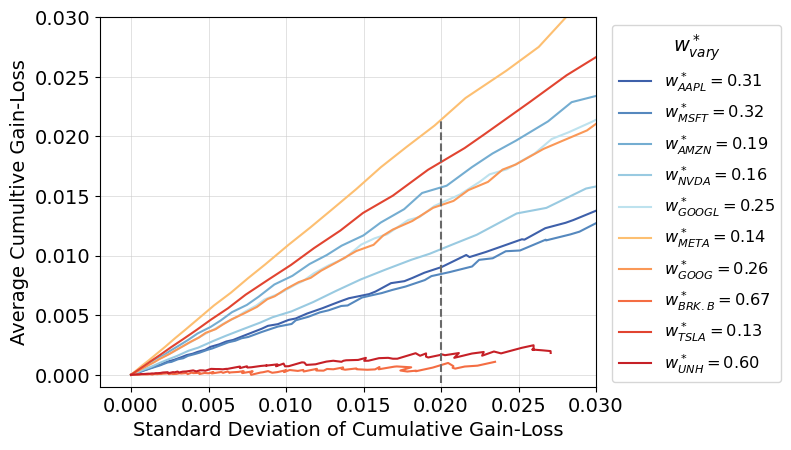

In [ ]:
comp_adj = [c.replace('-', '.') for c in comp_list1]
[plt.plot(std_m1_asset[c], GL_m1_asset[c], color = cm2[i], label = '$w_{%s}^*=$%.2f'%(a, weight_vary[c])) for (i, c), a in zip(enumerate(comp_list1), comp_adj)]
plt.xlabel('Standard Deviation of Cumulative Gain-Loss')
plt.ylabel('Average Cumultive Gain-Loss')
plt.axvline(x=0.02, ymin=0.01, ymax=0.72, ls = '--', color = 'dimgrey')
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
plt.xlim(-0.002, 0.03)
plt.ylim(-0.001, 0.03)
plt.legend(title = '$w_{vary}^*$', bbox_to_anchor=(1.0, 0.1, 0.39, 0.9), fontsize = 'small')
# plt.savefig('portfolio_gain_std_list.eps', format = 'eps', bbox_inches='tight', dpi =600)


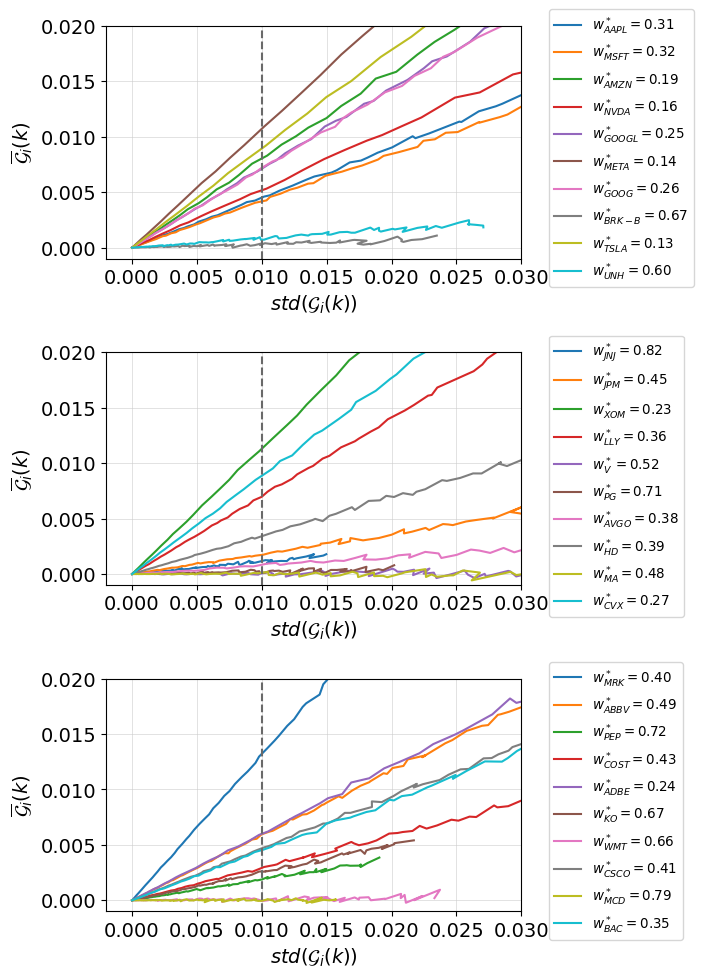

In [ ]:
plt.figure(figsize = (7.5, 10))
for i, comp in enumerate([comp_list1, comp_list2, comp_list3]):
    plt.subplot(3,1,i+1)
    [plt.plot(std_m1_asset[c], GL_m1_asset[c], label = '$w_{%s}^*=$%.2f'%(c, weight_vary[c])) for c in comp]
    plt.xlabel('$ {std}(\mathcal{G}_i(k))$')
    plt.ylabel('$\overline{\mathcal{G}}_i(k)$')
    plt.axvline(x=0.01, ls = '--', color = 'dimgrey')
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
    plt.xlim(-0.002, 0.03)
    plt.ylim(-0.001, 0.02)
    plt.legend(bbox_to_anchor=(1.05, -0.1, 0.3, 1.2), fontsize = 'x-small')
# plt.savefig('portfolio_gain_std_list.eps', format = 'eps', bbox_inches='tight', dpi =600)
plt.tight_layout()

## Backtesting using optimal weight

## test for different year

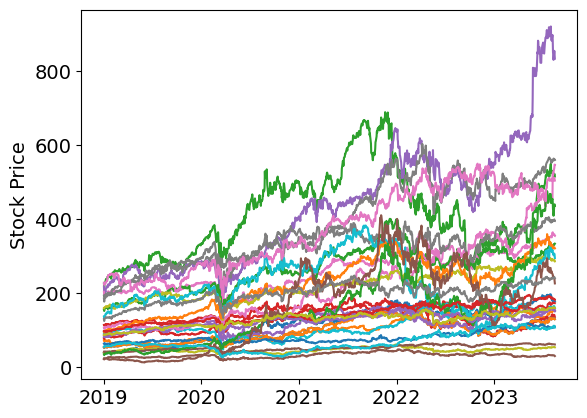

In [ ]:
plt.plot(SPY_Price)
plt.ylabel('Stock Price')
plt.show()

In [ ]:
SPY_Price[Data_train.iloc[-1].name:'2023-07-31']
# Data_test.T[Data_train.iloc[-1].name] = Data_train.iloc[-1]
# Data_test

,AAPL,ABBV,ADBE,AMZN,AVGO,BAC,BRK-B,COST,CSCO,CVX,...,MRK,MSFT,NVDA,PEP,PG,TSLA,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,129.378006,156.889603,336.529999,84.000000,552.192566,32.646069,308.899994,454.758179,46.556969,176.191818,...,109.452667,238.194717,146.100067,178.202515,148.740601,123.180000,526.138550,206.561981,140.178497,107.633781
2023-01-03,124.538658,157.637115,336.920013,85.820000,546.612671,33.030487,309.910004,451.550507,46.850143,170.792877,...,109.640106,237.956329,143.110870,176.969528,148.750427,108.099998,514.686523,206.194107,141.967941,103.935394
2023-01-04,125.823189,158.908844,341.410004,85.139999,553.288818,33.651470,314.549988,454.817963,46.840294,168.976883,...,110.567421,227.547348,147.449707,176.535507,149.398148,113.639999,500.654297,211.384018,142.126114,104.237900
2023-01-05,124.488876,158.714691,328.440002,83.120003,548.133606,33.582474,312.899994,448.472290,46.180294,172.019928,...,112.106369,220.803375,142.611023,174.690948,147.543304,110.339996,486.225128,209.892670,141.641693,106.570129
2023-01-06,129.069321,161.685303,332.750000,86.080002,581.129028,33.917606,318.690002,481.027588,47.598801,173.315659,...,113.290169,223.405624,148.549393,178.636520,151.056702,113.059998,486.264832,216.494385,145.111801,107.858215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,193.358887,141.630005,525.340027,129.130005,917.989990,32.150002,347.579987,565.190002,53.599998,162.559998,...,107.529999,350.238464,456.790009,191.360001,153.779999,265.279999,510.929993,238.242004,158.606155,104.820740
2023-07-26,194.237701,141.899994,514.549988,128.149994,893.090027,32.410000,349.799988,566.169983,53.220001,161.339996,...,107.139999,337.056366,454.519989,191.600006,153.940002,264.350006,508.000000,236.654999,159.174149,104.235535
2023-07-27,192.959427,148.850006,513.969971,128.250000,893.530029,31.950001,349.309998,561.830017,53.000000,159.660004,...,105.269997,330.021271,459.000000,188.529999,152.110001,255.710007,505.230011,233.999985,158.596207,104.562851


In [ ]:
# 可調整 training data, testing data 日期
Data_train = SPY_Price['2022-01-01':'2022-12-31']
# Data_test = SPY_Price['2023-01-01':'2023-07-31']
Data_test = SPY_Price['2022-12-30':'2023-07-31']
n = len(Data_test.columns)
n1 = len(Data_train)
n2 = len(Data_test)

# compute the initial allocation parameters vi
vGL = (Data_train.pct_change(n1-1).iloc[-1]).abs()/(Data_train.pct_change(n1-1).iloc[-1]).abs().sum()
vEW = pd.Series([1/n] * n, index = comp_list)
# vPW = (Data_train.iloc[-1] / sum(Data_train.iloc[-1]))

# find out the top 10 gain-loss for the training data
w_top = pd.Series(pd.Series(1,index = ((Data_train.pct_change(n1-1).iloc[-1]).abs().sort_values()[-10:].index)), index = comp_list).fillna(0)

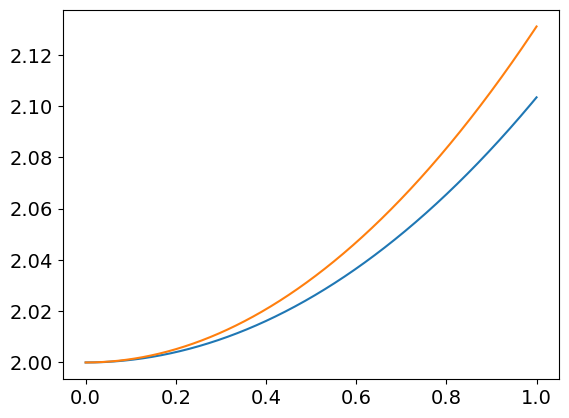

In [ ]:
d = -0.02
x = np.linspace(0, 1, 1000)
plt.plot(x, 2/(1-x**2 * d**2) **(252/2))
e = 9
plt.plot(x, ((1-x* d)/(1+x * d))**(e) +((1-x* d)/(1+x * d))**(-e) )

0.031052241785615164
0.002255310193752136
0.0383052195337481
0.05909294008548893
0.005296108038897573
0.05636415618090673
0.07109187020744634
0.005299055048639811
0.07346708246520683


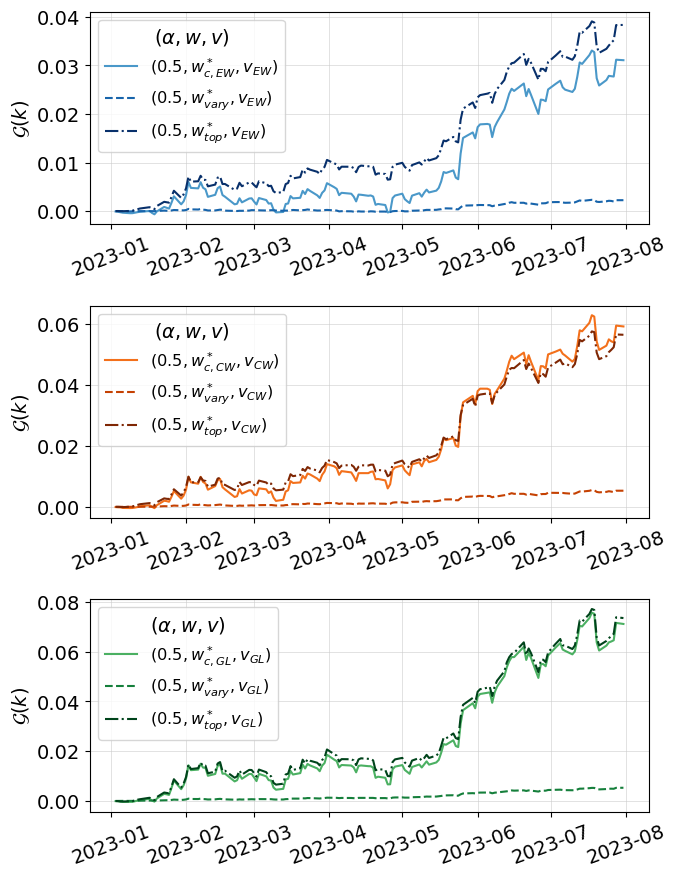

In [ ]:
Data_trade = Data_test
alpha = 0.5
V0 = 1
rf, tran_cost = 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}

plt.figure(figsize = (7,9))
j=1
for i, c, l in zip(optimal_w, color_list, ls_list):
    w = optimal_w[i]
    weight = pd.Series([w] * n, index = comp_list)
    vi = allocation[i]
    plt.subplot(3,1,j)

    # triple set (1/2, w_c*, v)
    print(GL_price_portfolio(0.5, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][2], ls = ls_list[0],
                             label = '$(0.5, w_{c,%s}^*,v_{%s})$' %(i, i)))

    # triple set (1/2, w_vary, v)
    print(GL_price_portfolio(0.5, weight_vary, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][1], ls = ls_list[1],
                             label = '$(0.5, w_{vary}^*, v_{%s})$' %(i)))

    # triple set (1/2, w_top * w_c*, v)
    print(GL_price_portfolio(0.5, w_top * w, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][0], ls = ls_list[2],
                             label = '$(0.5, w_{top}^*, v_{%s})$' %(i)))
    j+=1
    plt.tick_params(axis='x', labelrotation=20)
    plt.legend(title = r'$(\alpha, w, v)$', fontsize = 'small')
    plt.ylabel('$\mathcal{G}(k)$')
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

plt.tight_layout()
# plt.savefig('portfolio_trading_diff_parameters.eps', format = 'eps', bbox_inches='tight', dpi =600)

In [ ]:
# The trading performace matrix: gain-loss, standard deviation, Sharpe ratio and maximum drawdown
Data_trade = Data_test
performance = pd.DataFrame(index = ['Gain-Loss', 'std', 'Sharpe', 'MDD(%)'])

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}  # tune here to add another initial allocation vi

V0, alpha, cost, rf = 1, 0.5, 0.01, 3.88  # tune here to adjust the trading parameters V0, alpha, transaction cost, risk-free rate

for v in allocation:
    weight_c = pd.Series(optimal_w[v], index = comp_list)
    weight_top = pd.Series(w_top * optimal_w[v], index = comp_list)
    diff_weight = {'w_const': weight_c, 'w_top': weight_top, 'w_vary':weight_vary}  # tune here to add another optimal weight w
    vi = allocation[v]
    for w in diff_weight:
        VL_all = 0; VS_all = 0
        for i, comp in enumerate(comp_list):
            price = Data_trade[comp]
            X = price.pct_change(1).fillna(0)
            vl = V0 * vi[comp] * alpha * 100
            vs = V0 * vi[comp] * (1-alpha) * 100
            weight_comp = diff_weight[w][comp]

            VL = ((1 + weight_comp * (X - (cost/100)).T + (1 - weight_comp) * (rf / 100) / 365).T.cumprod(axis = 0)) * vl
            VS = ((1 - weight_comp * (X + (cost/100)).T).T.cumprod(axis = 0)) * vs
            VL_all += VL/100
            VS_all += VS/100

        V = VL_all + VS_all
        V_ret = pd.concat([pd.Series(1), V]).pct_change(1).dropna()

        profit = V[1:]
        Roll_Max = profit.cummax()
        Daily_Drawdown = profit/Roll_Max - 1.0
        Max_Daily_Drawdown = Daily_Drawdown.cummin()

        GL = (V-V0)[-1]  # Gain-Loss
        deviation = (V-V0).std()  # standard deviation
        MDD = Max_Daily_Drawdown[-1] * 100  # Maximum DrawDown
        Sharpe = (V_ret.mean()-rf/100/365) / V_ret.std() * np.sqrt(len(X))  # Sharpe ratio

        performance[w, v] = [GL, deviation, Sharpe,MDD]
performance.T

,Gain-Loss,std,Sharpe,MDD(%)
"(w_const, EW)",0.028613,0.009876,0.835121,-0.667458
"(w_top, EW)",0.036392,0.011375,1.527274,-0.596431
"(w_vary, EW)",0.002124,0.000743,-10.438652,-0.072137
"(w_const, CW)",0.054939,0.018582,1.512189,-1.035234
"(w_top, CW)",0.054042,0.017114,1.871412,-0.827809
"(w_vary, CW)",0.004977,0.001649,-5.091140,-0.073717
"(w_const, GL)",0.065442,0.021570,1.644083,-1.348269
"(w_top, GL)",0.068305,0.021886,1.826487,-1.296871
"(w_vary, GL)",0.005109,0.001594,-6.319034,-0.059209


In [ ]:
performance.round(4).T

,,Gain-Loss,std,Sharpe,MDD(%)
w_const,EW,0.0286,0.0099,0.8351,-0.6675
w_top,EW,0.0364,0.0114,1.5273,-0.5964
w_vary,EW,0.0021,0.0007,-10.4387,-0.0721
w_const,CW,0.0549,0.0186,1.5122,-1.0352
w_top,CW,0.0540,0.0171,1.8714,-0.8278
w_vary,CW,0.0050,0.0016,-5.0911,-0.0737
w_const,GL,0.0654,0.0216,1.6441,-1.3483
w_top,GL,0.0683,0.0219,1.8265,-1.2969
w_vary,GL,0.0051,0.0016,-6.3190,-0.0592


-0.18615134405293443
-0.060354520576231474
0.0654423029004716
0.19123912637717444
0.3170359498538773


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


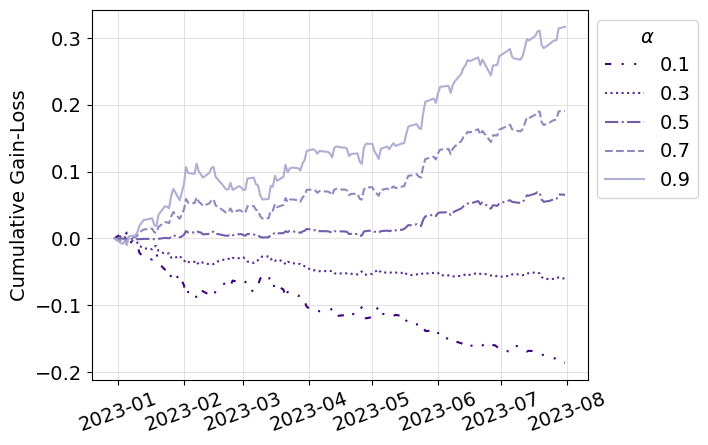

In [ ]:
# test
Data_trade = Data_test
V0 = 1
alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9]
weight = pd.Series([wGL] * n, index = comp_list)  # tune here to change another weight, w_{c, GL}
vi = vGL  # tune here to adjust another allocation, vi
rf , tran_cost = 3.88, 0.01

for i, alpha in enumerate(alpha_list):
    GL_price_portfolio(alpha, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = purple[i], ls = ls_list[4-i],
                             label = '%.1f' %alpha)

plt.ylabel('Cumulative Gain-Loss')
plt.tick_params(axis='x', labelrotation=20)
plt.legend(title = '$\\alpha$',bbox_to_anchor=(1.0, 1.0))
plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)
# plt.savefig('portfolio_trading_diff_alpha.eps', format = 'eps', bbox_inches='tight', dpi =600)

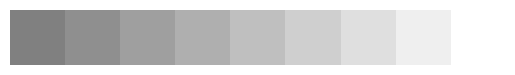

In [ ]:

# 定义起始颜色和结束颜色
end_color = 'white'

# 定义渐变的步数
num_steps = 9

# 创建自定义渐变色彩映射
cmap_blue = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['dodgerblue', end_color], N=num_steps)
cmap_orange = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['gray', end_color], N=num_steps)
cmap_green = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['seagreen', end_color], N=num_steps)

# 生成渐变色彩
gradient_blue = [cmap_blue(i / (num_steps - 1)) for i in range(num_steps)]
gradient_orange = [cmap_orange(i / (num_steps - 1)) for i in range(num_steps)]
gradient_green = [cmap_green(i / (num_steps - 1)) for i in range(num_steps)]

# 可视化渐变色彩
# gradient_colors = np.array(gradient_green)
# plt.imshow([gradient_green])
gradient_colors = np.array(gradient_orange)
plt.imshow([gradient_orange])
plt.axis('off')
plt.show()


In [ ]:
color1 = to_rgba('darkseagreen', alpha=0.3)
color2 = to_rgba('darkseagreen', alpha=0.6)


CI_color = {'CW': [gradient_orange[2], gradient_orange[4], gradient_orange[6]],
            'EW': [gradient_orange[2], gradient_orange[4], gradient_orange[6]],
            'GL': [gradient_orange[2], gradient_orange[4], gradient_orange[6]]}
#             'CW': [gradient_blue[1], gradient_blue[3], gradient_blue[5]],
#             'EW': ['slategrey', 'lightsteelblue', 'lavender'],
#             'GL': [gradient_green[1], gradient_green[3], gradient_green[5]]}#'lightgreen', color_list['green'][4]]}
# CI_color = [(0.6, 0.6, 0.6), (0.75, 0.75, 0.75), (0.9, 0.9, 0.9)]

In [ ]:
# compute the trading gain-loss
Data_trade = Data_test
alpha = 0.5
V0 = 1
rf, tran_cost = 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}
account_value = pd.DataFrame()

# plt.figure(figsize = (8,9))
j=1
for i, c, l in zip(optimal_w, color_list, ls_list):
    w = optimal_w[i]
    weight = pd.Series([w] * n, index = comp_list)
    vi = allocation[i]
#     plt.subplot(3,1,j)

    # triple set (1/2, w_c*, v)
    account_value[i,'c'] = GL_price_portfolio(0.5, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost, gain = True)

    # triple set (1/2, w_top * w_c*, v)
    account_value[i,'top'] = GL_price_portfolio(0.5, w_top * w, V0, vi, Data_trade, Rf = rf, cost = tran_cost, gain = True)

    # triple set (1/2, w_vary, v)
    account_value[i,'vary'] =  GL_price_portfolio(0.5, weight_vary, V0, vi, Data_trade, Rf = rf, cost = tran_cost, gain = True)

    j+=1

account_value

,"(EW, c)","(EW, top)","(EW, vary)","(CW, c)","(CW, top)","(CW, vary)","(GL, c)","(GL, top)","(GL, vary)"
Date,,,,,,,,,
2022-12-30,-0.000065,0.000014,3.136986e-07,-0.000068,0.000010,0.000004,-0.000066,-0.000025,0.000010
2023-01-03,-0.000130,0.000028,5.788831e-07,-0.000136,0.000019,0.000008,-0.000133,-0.000051,0.000019
2023-01-04,-0.000309,-0.000083,7.443811e-06,-0.000379,-0.000127,0.000011,-0.000512,-0.000389,0.000023
2023-01-05,-0.000341,-0.000081,2.343776e-05,-0.000299,-0.000124,0.000045,-0.000553,-0.000426,0.000035
2023-01-06,-0.000531,-0.000135,-3.181528e-06,-0.000669,-0.000211,0.000008,-0.000828,-0.000597,0.000024
...,...,...,...,...,...,...,...,...,...
2023-07-25,0.025315,0.032085,1.998715e-03,0.050651,0.048255,0.004814,0.057925,0.060075,0.004713
2023-07-26,0.025314,0.032721,1.967190e-03,0.050063,0.049069,0.004692,0.058406,0.061057,0.004740
2023-07-27,0.025388,0.033353,1.866529e-03,0.049904,0.050072,0.004535,0.059228,0.062278,0.004717


In [ ]:
# account_value.to_csv('trading_gainloss.csv')

In [ ]:
account_value = pd.read_csv('trading_gainloss.csv', index_col = 0)

In [ ]:
repeat = 10000  # tune here to adjust the simulation times
day = len(Data_test)-1
Data = Data_train
Return = Data_train.pct_change(1)
U, D = u_d_movement(Return)  # estimate upward and downward movement factor
Data_trade = Data_test
V0, alpha, rf, tran_cost = 1, 0.5, 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost


n = len(Data.columns)
S0 = Data.iloc[-1]
correlation = Return.corr() - np.identity(n)  # correlation matrix, Gamma
m = 1
Phi = Markov_coef_portfolio(m, Return, U, D, correlation)  # estimate the phi_i parameters
probability = probability_portfolio(m, day, Phi, U, D, Return, correlation)  # estimate the probability recursion model

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}

CI_c = pd.DataFrame()
CI_vary = pd.DataFrame()
CI_top = pd.DataFrame()

for i, c in zip(optimal_w, color_list):
    vi = allocation[i]
    w = optimal_w[i]
    weight_c = pd.Series([w] * n, index = comp_list)

    # triple set (1/2, w_c*, v)
    simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)  # Monte Carlo simulation
    gain = GL_price_portfolio(0.5, weight_c, V0, vi, simu_price, Rf = rf, cost = tran_cost, ret = True, gain = True)  # set 'gain=True' to get the gain-loss matrix
    gbar, deviation = gain.T.mean(), gain.T.std()
    CI_up, CI_down = gbar + 1.96 * deviation, gbar - 1.96 * deviation
    CI_c[i, 'up'] = CI_up
    CI_c[i, 'down'] = CI_down

    # triple set (1/2, w_vary, v)
    simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)  # Monte Carlo simulation
    gain = GL_price_portfolio(0.5, weight_vary, V0, vi, simu_price, Rf = rf, cost = tran_cost, ret = True, gain = True)  # set 'gain=True' to get the gain-loss matrix
    gbar, deviation = gain.T.mean(), gain.T.std()
    CI_up, CI_down = gbar + 1.96 * deviation, gbar - 1.96 * deviation
    CI_vary[i, 'up'] = CI_up
    CI_vary[i, 'down'] = CI_down

    # triple set (1/2, w_top * w_c*, v)
    simu_price = binomial_price_portfolio(repeat, day, probability, S0, U, D, ret = True)  # Monte Carlo simulation
    gain = GL_price_portfolio(0.5, w_top, V0, vi, simu_price, Rf = rf, cost = tran_cost, ret = True, gain = True)  # set 'gain=True' to get the gain-loss matrix
    gbar, deviation = gain.T.mean(), gain.T.std()
    CI_up, CI_down = gbar + 1.96 * deviation, gbar - 1.96 * deviation
    CI_top[i, 'up'] = CI_up
    CI_top[i, 'down'] = CI_down

In [ ]:
# CI_c.to_csv('CI_c.csv')
# CI_vary.to_csv('CI_vary.csv')
# CI_top.to_csv('CI_top.csv')

In [ ]:
CI_c = pd.read_csv('CI_c.csv', index_col = 0)
CI_vary = pd.read_csv('CI_vary.csv', index_col = 0)
CI_top = pd.read_csv('CI_top.csv', index_col = 0)


0.002123984625260311
0.0049774804389870475
0.005109378187228897


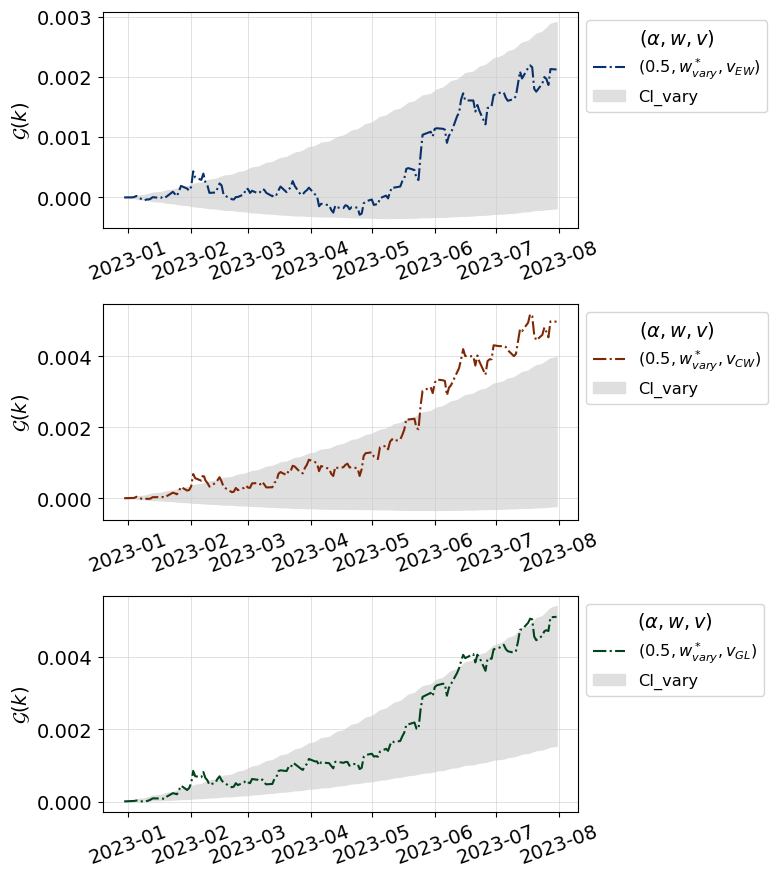

In [ ]:
Data_trade = Data_test
alpha = 0.5
V0 = 1
rf, tran_cost = 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}

plt.figure(figsize = (8,9))
j=1
for i, c, l in zip(optimal_w, color_list, ls_list):
    w = optimal_w[i]
    weight = pd.Series([w] * n, index = comp_list)
    vi = allocation[i]
    plt.subplot(3,1,j)

    # triple set (1/2, w_c*, v)
#     trade_c, = (GL_price_portfolio(0.5, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
#                              plot = True, color = color_list[c][2], ls = ls_list[0],
#                              label = '$(0.5, w_{c,%s}^*,v_{%s})$' %(i, i)))

    # triple set (1/2, w_top * w_c*, v)
#     trade_top, = (GL_price_portfolio(0.5, w_top * w, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
#                              plot = True, color = color_list[c][1], ls = ls_list[1],
#                              label = '$(0.5, w_{top}^*, v_{%s})$' %(i)))

    # triple set (1/2, w_vary, v)
    trade_vary, =  (GL_price_portfolio(0.5, weight_vary, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][0], ls = ls_list[2],
                             label = '$(0.5, w_{vary}^*, v_{%s})$' %(i)))

#     plot_ci_top  = plt.fill_between(Data_trade.index, CI_top[i, 'up'], CI_top[i, 'down'], color = CI_color[i][0], label = 'CI_top')#, label = 'CI: $w_{top}^*$')
#     plot_ci_c    = plt.fill_between(Data_trade.index, CI_c[i, 'up']  , CI_c[i, 'down']  , color = CI_color[i][1], label = 'CI_constant')#, label = 'CI: $w_{c,%s}^*,v_{%s})$' %i)

    plot_ci_vary = plt.fill_between(Data_trade.index, CI_vary[i, 'up'], CI_vary[i, 'down'], color = CI_color[i][2], label = 'CI_vary')#, label = 'CI: $w_{vary}^*$')


    j+=1
    plt.tick_params(axis='x', labelrotation=20)
#     plt.legend(title = r'$(\alpha, w, v)$', fontsize = 'small')
    plt.legend(handles = [trade_vary, plot_ci_vary],#[trade_c,plot_ci_c],#, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
               title = r'$(\alpha, w, v)$', fontsize = 'small',bbox_to_anchor=(1.0, 1.0))
    plt.ylabel('$\mathcal{G}(k)$')
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

plt.tight_layout()
# plt.savefig('portfolio_trading_diff_parameters_CI.eps', format = 'eps', bbox_inches='tight', dpi =600)

0.02861305568882022
0.03639231154581424
0.002123984625260311
0.054938863738762


C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child4' of <matplotlib.collections.PolyCollection object at 0x000001E4036A0110> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child3' of <matplotlib.collections.PolyCollection object at 0x000001E4013E4550> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child5' of <matplotlib.collections.PolyCollection object at 0x000001E4036A1290> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],


0.05404234947143949
0.0049774804389870475


C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child4' of <matplotlib.collections.PolyCollection object at 0x000001E4036B7E50> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child3' of <matplotlib.collections.PolyCollection object at 0x000001E40145DF50> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child5' of <matplotlib.collections.PolyCollection object at 0x000001E4036C5010> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],


0.0654423029004716
0.0683049116953034
0.005109378187228897


C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child4' of <matplotlib.collections.PolyCollection object at 0x000001E4036EEED0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child3' of <matplotlib.collections.PolyCollection object at 0x000001E40F0A4590> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
C:\Users\acer\AppData\Local\Temp\ipykernel_3552\1638009706.py:40: UserWarning: The label '_child5' of <matplotlib.collections.PolyCollection object at 0x000001E4036EFDD0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
The PostScript backend does not support transp

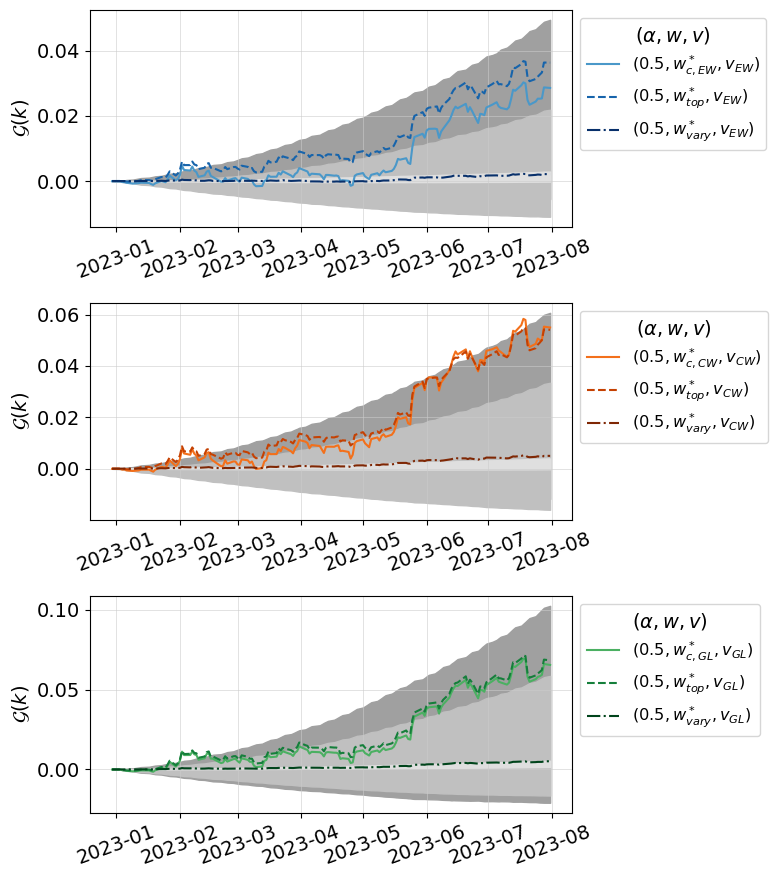

In [ ]:
Data_trade = Data_test
alpha = 0.5
V0 = 1
rf, tran_cost = 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}

plt.figure(figsize = (8,9))
j=1
for i, c, l in zip(optimal_w, color_list, ls_list):
    w = optimal_w[i]
    weight = pd.Series([w] * n, index = comp_list)
    vi = allocation[i]
    plt.subplot(3,1,j)

    # triple set (1/2, w_c*, v)
    trade_c, = (GL_price_portfolio(0.5, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][2], ls = ls_list[0],
                             label = '$(0.5, w_{c,%s}^*,v_{%s})$' %(i, i)))

    # triple set (1/2, w_top * w_c*, v)
    trade_top, = (GL_price_portfolio(0.5, w_top * w, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][1], ls = ls_list[1],
                             label = '$(0.5, w_{top}^*, v_{%s})$' %(i)))

    # triple set (1/2, w_vary, v)
    trade_vary, =  (GL_price_portfolio(0.5, weight_vary, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][0], ls = ls_list[2],
                             label = '$(0.5, w_{vary}^*, v_{%s})$' %(i)))

    plot_ci_top  = plt.fill_between(Data_trade.index, CI_top[i, 'up'], CI_top[i, 'down'], color = CI_color[i][0])#, label = 'CI: $w_{top}^*$')
    plot_ci_c    = plt.fill_between(Data_trade.index, CI_c[i, 'up']  , CI_c[i, 'down']  , color = CI_color[i][1])#, label = 'CI: $w_{c,%s}^*,v_{%s})$' %i)
    plot_ci_vary = plt.fill_between(Data_trade.index, CI_vary[i, 'up'], CI_vary[i, 'down'], color = CI_color[i][2])#, label = 'CI: $w_{vary}^*$')


    j+=1
    plt.tick_params(axis='x', labelrotation=20)
#     plt.legend(title = r'$(\alpha, w, v)$', fontsize = 'small')
    plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
               title = r'$(\alpha, w, v)$', fontsize = 'small',bbox_to_anchor=(1.0, 1.0))
    plt.ylabel('$\mathcal{G}(k)$')
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

plt.tight_layout()
plt.savefig('portfolio_trading_diff_parameters_CI.eps', format = 'eps', bbox_inches='tight', dpi =600)

0.02861305568882022
0.03639231154581424
0.002123984625260311
0.054938863738762
0.05404234947143949
0.0049774804389870475
0.0654423029004716
0.0683049116953034
0.005109378187228897


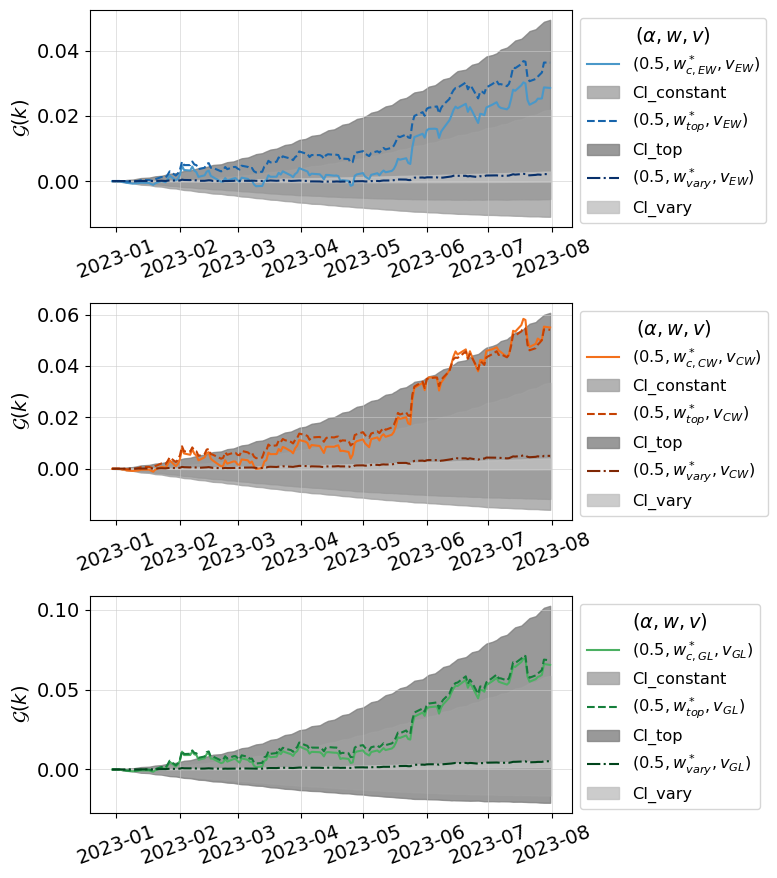

In [ ]:
Data_trade = Data_test
alpha = 0.5
V0 = 1
rf, tran_cost = 3.88, 0.01  # tune here to adjust the risk-free rate and transaction cost

optimal_w = {'EW': wEW, 'CW': wCW, 'GL': wGL}
allocation = {'EW': vEW, 'CW': vCW, 'GL': vGL}

plt.figure(figsize = (8,9))
j=1
for i, c, l in zip(optimal_w, color_list, ls_list):
    w = optimal_w[i]
    weight = pd.Series([w] * n, index = comp_list)
    vi = allocation[i]
    plt.subplot(3,1,j)

    # triple set (1/2, w_c*, v)
    trade_c, = (GL_price_portfolio(0.5, weight, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][2], ls = ls_list[0],
                             label = '$(0.5, w_{c,%s}^*,v_{%s})$' %(i, i)))

    # triple set (1/2, w_top * w_c*, v)
    trade_top, = (GL_price_portfolio(0.5, w_top * w, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][1], ls = ls_list[1],
                             label = '$(0.5, w_{top}^*, v_{%s})$' %(i)))

    # triple set (1/2, w_vary, v)
    trade_vary, =  (GL_price_portfolio(0.5, weight_vary, V0, vi, Data_trade, Rf = rf, cost = tran_cost,
                             plot = True, color = color_list[c][0], ls = ls_list[2],
                             label = '$(0.5, w_{vary}^*, v_{%s})$' %(i)))

    plot_ci_top  = plt.fill_between(Data_trade.index, CI_top[i, 'up'], CI_top[i, 'down'], color = gradient_orange[0], alpha = 0.8, label = 'CI_top')#, label = 'CI: $w_{top}^*$')
    plot_ci_c    = plt.fill_between(Data_trade.index, CI_c[i, 'up']  , CI_c[i, 'down']  , color = gradient_orange[2], alpha = 0.8, label = 'CI_constant')#, label = 'CI: $w_{c,%s}^*,v_{%s})$' %i)
    plot_ci_vary = plt.fill_between(Data_trade.index, CI_vary[i, 'up'], CI_vary[i, 'down'], color = gradient_orange[4], alpha = 0.8, label = 'CI_vary')#, label = 'CI: $w_{vary}^*$')


    j+=1
    plt.tick_params(axis='x', labelrotation=20)
#     plt.legend(title = r'$(\alpha, w, v)$', fontsize = 'small')
    plt.legend(handles = [trade_c,plot_ci_c, trade_top,plot_ci_top, trade_vary, plot_ci_vary],
               title = r'$(\alpha, w, v)$', fontsize = 'small',bbox_to_anchor=(1.0, 1.0))
    plt.ylabel('$\mathcal{G}(k)$')
    plt.grid(color = (0.8, 0.8, 0.8), lw = 0.4)

plt.tight_layout()
# plt.savefig('portfolio_trading_diff_parameters_CI.eps', format = 'eps', bbox_inches='tight', dpi =600)